<a href="https://colab.research.google.com/github/chcorophyll/my_deeplearning_cookbook/blob/master/my_Reusing_a_pretrained_image_recognition_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/chcorophyll/deep_learning_cookbook.git

Cloning into 'deep_learning_cookbook'...
remote: Enumerating objects: 427, done.
remote: Total 427 (delta 0), reused 0 (delta 0), pack-reused 427
Receiving objects: 100% (427/427), 160.26 MiB | 33.97 MiB/s, done.
Resolving deltas: 100% (207/207), done.
Checking out files: 100% (86/86), done.


In [0]:
!ls

deep_learning_cookbook	images	pet_images  sample_data


In [0]:
import os

path_org = os.getcwd()
path_data = os.path.join(path_org, "deep_learning_cookbook")
os.chdir(path_data)

In [0]:
!pip install pillow

In [0]:
%matplotlib inline

from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

from keras import applications
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input

from scipy import ndimage
from matplotlib.pyplot import imshow
from PIL import Image
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
import numpy as np

Using TensorFlow backend.


In [0]:
model = VGG16(weights="imagenet", include_top=True)
model.summary()

W0701 12:37:15.904784 140149893261184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 12:37:15.944124 140149893261184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 12:37:15.951550 140149893261184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 12:37:15.999028 140149893261184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 6s 0us/step


W0701 12:37:22.400134 140149893261184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0701 12:37:22.401723 140149893261184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

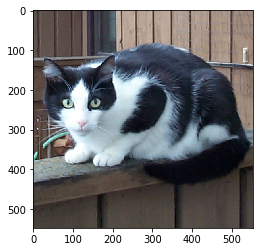

In [0]:
img = Image.open("data/cat.jpg")
w, h = img.size
s = min(w, h)
y = (h-s)//2
x = (w-s)//2
img = img.crop((x, y, s, s))
imshow(np.asarray(img))

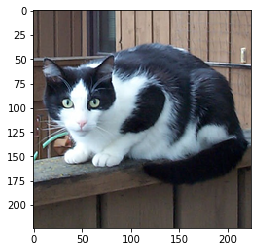

In [0]:
target_size = max(x for x in model.layers[0].input_shape if x)
img = img.resize((target_size, target_size), Image.ANTIALIAS)
imshow(np.asarray(img))

In [0]:
np_img = image.img_to_array(img)
img_batch = np.expand_dims(np_img, axis=0)
pre_processed = preprocess_input(img_batch)
pre_processed.shape

(1, 224, 224, 3)

In [0]:
features = model.predict(pre_processed)
features.shape

(1, 1000)

In [0]:
decode_predictions(features, top=5)

40960/35363 [==================================] - 0s 0us/step


[[('n02124075', 'Egyptian_cat', 0.14703201),
  ('n04040759', 'radiator', 0.12125659),
  ('n02123045', 'tabby', 0.09763843),
  ('n03207941', 'dishwasher', 0.047418647),
  ('n02971356', 'carton', 0.0470364)]]

 **Images as embeddings**

In [0]:
!pip install flickrapi

     |████████████████████████████████| 61kB 4.7MB/s 


In [0]:
import flickrapi
from IPython.display import HTML, Image, display
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
import os
import multiprocessing
from sklearn.model_selection import train_test_split
from functools import partial
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
from glob import glob
from sklearn import svm
import numpy.linalg

In [0]:
# Replace with your own. These belong to a dissabled app:
FLICKR_KEY = '6613d4f5965a483e1c7492dad741a412'
FLICKR_SECRET = '9bf41d5409c4bbcb'

In [0]:
flickr = flickrapi.FlickrAPI(FLICKR_KEY, FLICKR_SECRET, format='parsed-json')

In [0]:
def flickr_url(photo, size=""):
    url = "http://farm{farm}.staticflickr.com/{server}/{id}_{secret}{size}.jpg"
    if size:
        size = "_" + size
    return url.format(size=size, **photo)

In [0]:
res = flickr.photos.search(text="cat", per_page="10", sort="relcvance")

In [0]:
photos = res['photos']['photo']
tags = ['<img src="{}" width="150" style="display:inline"/>'.format(flickr_url(photo)) for photo in photos]
HTML(''.join(tags))

In [0]:
def fetch_photo(dir_name, photo):
    urlretrieve(flickr_url(photo), os.path.join(dir_name, photo['id'] + '.jpg'))

def fetch_image_set(query, dir_name=None, count=250, sort='relevance'):
    res = flickr.photos.search(text='"{}"'.format(query), 
                               per_page=count, sort=sort)['photos']['photo']
    dir_name = dir_name or query
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    with multiprocessing.Pool() as p:
        p.map(partial(fetch_photo, dir_name), res)

In [0]:
fetch_image_set('cat')
fetch_image_set('dog')

In [0]:
model = VGG16(weights='imagenet', include_top=True)

In [0]:
images = [image.load_img(p, target_size=(224, 224)) 
          for p in glob('cat/*jpg') + glob('dog/*jpg')]
tensor = np.asarray([image.img_to_array(img) for img in images])

In [0]:
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [0]:
p = model.predict(tensor)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(p, [1] * 250 + [0] * 249, test_size=0.20, random_state=42)

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
sum(1 for p, t in zip(clf.predict(X_test), y_test) if p != t)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


14

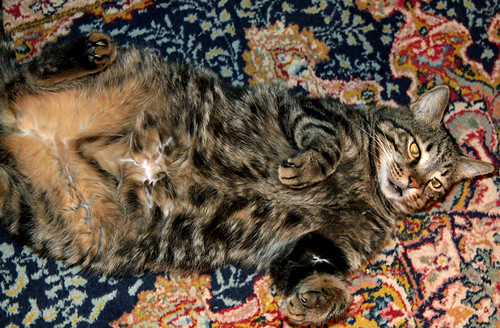

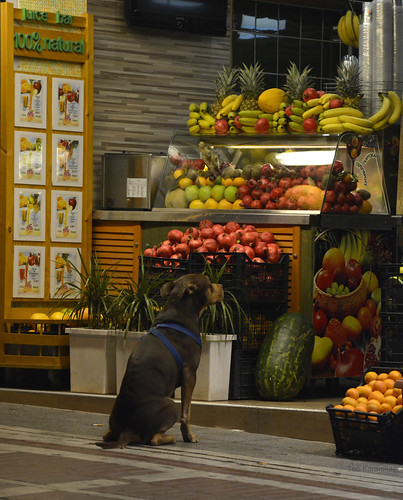

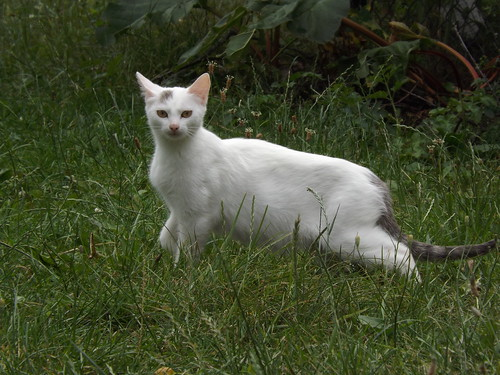

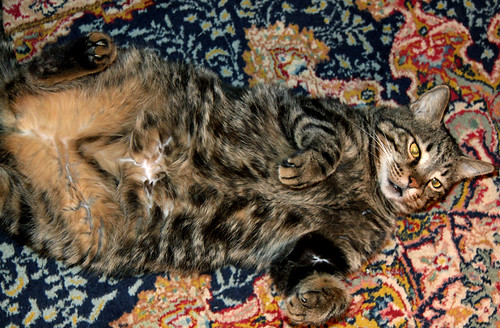

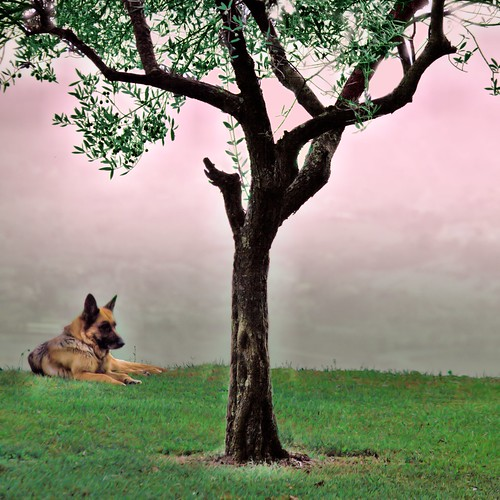

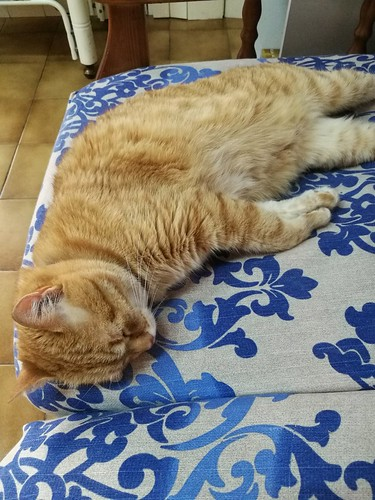

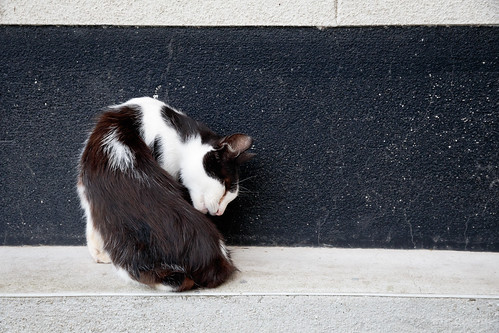

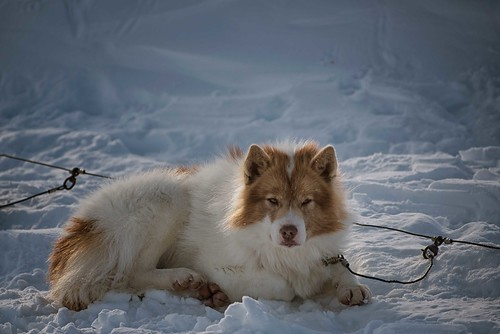

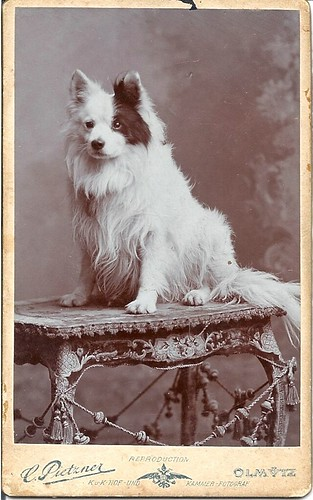

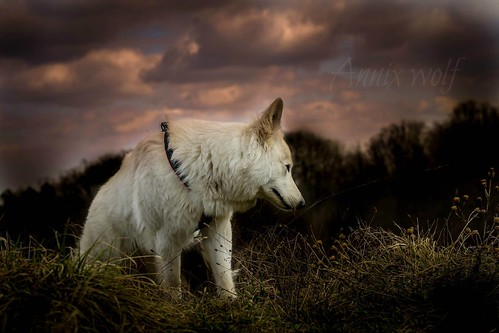

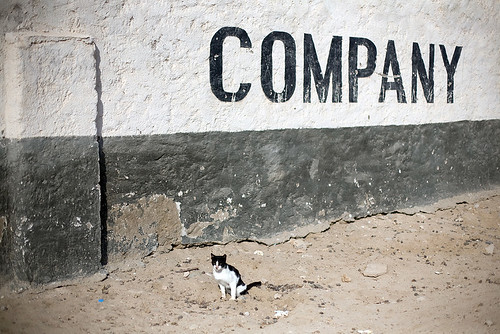

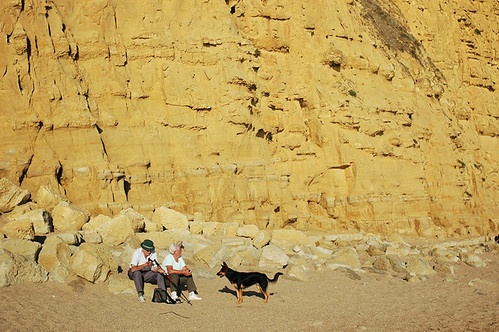

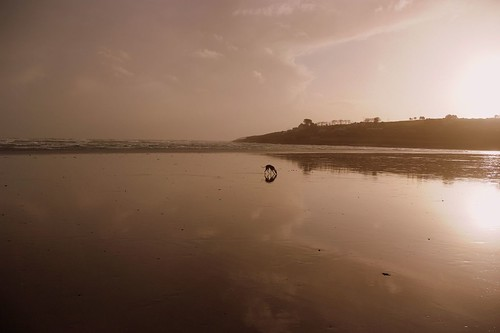

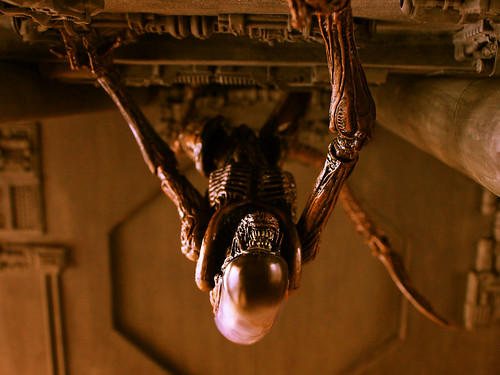

In [0]:
mm = {tuple(a): b for a, b in zip(p, glob('cat/*jpg') + glob('dog/*jpg'))}
wrong = [mm[tuple(a)] for a, p, t in zip(X_test, clf.predict(X_test), y_test) if p != t]

for x in wrong:
    display(Image(x, width=150))

In [0]:
fetch_image_set('cat', dir_name='maybe_cat2', count=100, sort='recent')

URLError: ignored

In [0]:
maybe_cat_fns = glob('maybe_cat/*jpg')
maybe_cats = [image.load_img(p, target_size=(224, 224)) 
              for p in maybe_cat_fns]
maybe_cat_tensor = np.asarray([image.img_to_array(img) 
                              for img in maybe_cats])
maybe_cat_vectors = model.predict(maybe_cat_tensor)

In [0]:
centroid = maybe_cat_vectors.sum(axis=0) / len(maybe_cats)
centroid

In [0]:
diffs = maybe_cat_vectors - centroid
distances = numpy.linalg.norm(diffs, axis=1)

In [0]:
sorted_idxs = np.argsort(distances)
for worst_cat_idx in sorted_idxs[-10:]:
    display(Image(maybe_cat_fns[worst_cat_idx], width=150))

In [0]:
to_drop = 90
sorted_idxs_i = sorted_idxs
for i in range(5):
    centroid_i = maybe_cat_vectors[sorted_idxs_i[:-to_drop]].sum(axis=0) / (len(maybe_cat_fns) - to_drop)
    distances_i = numpy.linalg.norm(maybe_cat_vectors - centroid_i, axis=1)
    sorted_idxs_i = np.argsort(distances_i)

In [0]:
for worst_cat_idx in sorted_idxs_i[:5]:
    display(Image(maybe_cat_fns[worst_cat_idx], width=150))

**Retraining**

In [3]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.utils import get_file
import tarfile
import os
import numpy as np
import json
from collections import Counter
from keras.optimizers import SGD

Using TensorFlow backend.


In [4]:
path = get_file('pet_images', 'http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz')
tar = tarfile.open(path)
tar.extractall()
tar.close()
os.rename("images", "pet_images")

791920640/791918971 [==============================] - 24s 0us/step


In [5]:
pet_images_fn = [fn for fn in os.listdir("pet_images") 
                 if fn.endswith(".jpg")]
labels = []
idx_to_labels = []
label_to_idx = {}
for fn in pet_images_fn:
    label, _ = fn.rsplit("_", 1)
    if not label in label_to_idx:
        label_to_idx[label] = len(idx_to_labels)
        idx_to_labels.append(label)
    labels.append(label_to_idx[label])  
len(idx_to_labels)

37

In [0]:
def fetch_pet(pet):
    img = image.load_img("pet_images/"+pet, target_size=(299, 299))
    return image.img_to_array(img)
img_vetor = np.asarray([fetch_pet(pet) for pet in pet_images_fn])

In [0]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
    layer.trainable = False
pool_2d = GlobalAveragePooling2D(name='pool_2d')(base_model.output)
dense = Dense(1024, name='dense', activation='relu')(pool_2d)
predictions = Dense(len(idx_to_labels), activation='softmax')(dense)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [0]:
y = np.zeros((len(labels), len(idx_to_labels)))
for idx, label in enumerate(labels):
    y[idx][label] = 1

model.fit(
    img_vector, y,
    batch_size=128,
    epochs=15,
    verbose=2
)

In [0]:
unfreeze = False
for layer in base_model.layers:
    if unfreeze:
        layer.trainable = True
    if layer.name == 'mixed9':
        unfreeze = True
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
json.dump(idx_to_labels, open('zoo/09.3 pet_labels.json', 'w'))
model.save('zoo/09.3 retrained pet recognizer.h5')